In [1]:
# infrastructure imports
from arrow import now

In [2]:
# functional imports
from matplotlib.pyplot import plot
from numpy import unique
from pandas import get_dummies
from pandas import read_csv
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
train_fname = '../input/titanic/train.csv'
train_df = read_csv(filepath_or_buffer=train_fname)
print('{}: train shape: {}'.format(now(), train_df.shape))

2022-12-19T18:49:57.084708+00:00: train shape: (891, 12)


In [4]:
# use a function to prepare our data so we can apply the same transformation to train and test
def prepare(input_df: DataFrame) -> DataFrame:
    # one-hot encoding for categorical columns Sex, Pclass, Embarked
    drop_columns = ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin']
    drop_columns = [column for column in drop_columns if column in input_df.columns]
    result_df = get_dummies(data=input_df, columns=['Sex', 'Pclass', 'Embarked',]).drop(columns=drop_columns)
    # fill in median values 
    for column in ['Age', 'Fare']:
        result_df[column + 'Null'] = result_df[column].isnull().astype(int)
    median_age = input_df['Age'].dropna().median()
    median_fare = input_df['Fare'].dropna().median()
    result_df['Age'] = result_df['Age'].fillna(median_age)
    result_df['Fare'] = result_df['Fare'].fillna(median_fare)
    return result_df

prepared_df = prepare(input_df=train_df)

In [5]:
fit_intercept = True
max_iter = 4000
penalty = ['none', 'l1', 'l2', 'elasticnet'][2]
random_state = 1
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'][4]
# solver = sag + penalty = l2 -> 0.76794
# solver = lbfgs + penalty = l2 -> 0.77033
model = LogisticRegression(fit_intercept=fit_intercept, max_iter=max_iter, penalty=penalty, random_state=random_state,
                          solver=solver, verbose=0)
model.fit(X=prepared_df, y=train_df['Survived'])
# get the accuracy score
score = accuracy_score(y_true=train_df['Survived'], y_pred=model.predict(X=prepared_df))
print('{}: score: {:0.4f}'.format(now(), score))

2022-12-19T18:49:57.935326+00:00: score: 0.8025


{0: 589, 1: 302}

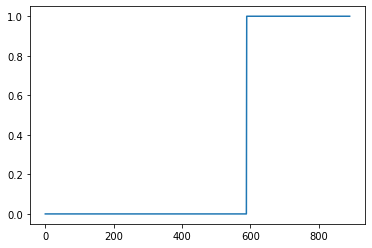

In [6]:
y_pred = model.predict(X=prepared_df)
plot(sorted(y_pred.tolist()), )
values, counts = unique(y_pred, return_counts=True)
dict(zip(values, counts))

In [7]:
# now predict
test_fname = '../input/titanic/test.csv'
test_df = read_csv(filepath_or_buffer=test_fname)
print('{}: test shape: {}'.format(now(), test_df.shape))
prepared_test_df = prepare(input_df=test_df)
test_df['Survived'] = model.predict(X=prepared_test_df)
result_columns = ['PassengerId', 'Survived']
result_fname = './submission.csv'
test_df[result_columns].to_csv(index=False, path_or_buf=result_fname,)
print('{}: wrote submission to {}'.format(now(), result_fname))
# trivial model is everyone dies - score 0.622
test_df['Trivial_Survived'] = 0

2022-12-19T18:49:58.277663+00:00: test shape: (418, 11)
2022-12-19T18:49:58.295639+00:00: wrote submission to ./submission.csv
